In [1]:
# These scripts are used to parse my data into

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

target_dir = "Bike 07-06-23 8:52"
target_dir2 = "Bike 07-06-23 14:27"

In [2]:
from statistics import mean

def time_diff(df):
    res = []
    for i in range(len(df["Time (s)"]) - 1):
        val1 = df["Time (s)"][i]
        val2 = df["Time (s)"][i + 1]
        
        res.append(val2 - val1)
    return mean(res)

def read_phyphox(parent_dir):
    acc = pd.read_csv(os.path.join(parent_dir, "Phyphox", "Accelerometer.csv"))
    gyro = pd.read_csv(os.path.join(parent_dir, "Phyphox", "Gyroscope.csv"))
    loc = pd.read_csv(os.path.join(parent_dir, "Phyphox", "Location.csv"))
        
    data_len = min(len(acc), len(gyro))
    acc = acc[0:data_len]
    gyro = gyro[0:data_len]
        
    time_step = mean([time_diff(acc), time_diff(gyro)])
    
    for i in range(data_len):
        time = time_step * i
        acc["Time (s)"][i] = time
        gyro["Time (s)"][i] = time
    
    acc.set_index('Time (s)', inplace=True)
    gyro.set_index('Time (s)', inplace=True)
    loc.set_index('Time (s)', inplace=True)
        
            
    merged = acc.join(gyro, how="outer")
    merged = pd.concat([merged, loc]).sort_index().interpolate()
    
    # Rename columns
    merged.index.names = ["time"]
    merged.rename(inplace=True, columns={
        "Acceleration x (m/s^2)": "acceleration_x",
        "Acceleration y (m/s^2)": "acceleration_y",
        "Acceleration z (m/s^2)": "acceleration_z",
        "Gyroscope x (rad/s)": "gyroscope_x",
        "Gyroscope y (rad/s)": "gyroscope_y",
        "Gyroscope z (rad/s)": "gyroscope_z",
        "Latitude (°)": "latitude",
        "Longitude (°)": "longitude",
        "Height (m)": "height",
        "Velocity (m/s)": "velocity",
        "Direction (°)": "direction",
        "Horizontal Accuracy (m)": "h_accuracy",
        "Vertical Accuracy (m)": "v_accuracy",

    })
    merged = merged.dropna()
    
    time_df = pd.read_csv(os.path.join(parent_dir, "Phyphox", "meta", "time.csv"))
    start_time = time_df.loc[time_df["event"] == "START"]["system time"][0]
    
    merged.reset_index(inplace=True)
    merged['time'] = pd.to_datetime(merged['time'] + start_time, unit='s')
    return merged

read_phyphox(target_dir)

,time,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,latitude,longitude,height,velocity,direction,h_accuracy,v_accuracy
0,2023-06-07 06:22:51.237444864,1.479975,4.688025,8.505450,-0.083256,-0.035956,-0.047644,52.278535,4.824785,-67.529845,0.758701,64.440002,9.10,91.699997
1,2023-06-07 06:22:51.357940992,0.751950,3.868050,9.076950,-0.041250,-0.046475,-0.062150,52.278468,4.824891,-69.529879,0.701824,58.365002,7.05,89.599998
2,2023-06-07 06:22:51.751848960,1.387300,4.062050,8.925950,-0.119212,0.199558,-0.065450,52.278402,4.824997,-71.529913,0.644947,52.290001,5.00,87.500000
3,2023-06-07 06:22:52.240046080,2.022650,4.256050,8.774950,-0.197175,0.445592,-0.068750,52.278388,4.825015,-74.229921,1.020694,24.639999,3.50,85.500000
4,2023-06-07 06:22:52.357411328,2.658000,4.450050,8.623950,-0.275137,0.691625,-0.072050,52.278392,4.825022,-74.629912,0.946574,24.105000,3.40,82.450001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,2023-06-07 06:52:37.411697664,6.423000,-10.324051,1.669050,0.150287,-0.078237,-0.280775,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000
3569,2023-06-07 06:52:38.411168000,13.989000,-12.897000,-1.638000,1.387787,3.768462,-3.214887,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000
3570,2023-06-07 06:52:39.410638592,0.193950,3.823950,9.574950,-0.194150,0.261525,-0.985875,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000
3571,2023-06-07 06:52:40.410108928,0.586050,4.098000,7.506001,-0.145200,0.679525,0.005225,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000


In [3]:
def read_samsung_health(parent_dir):
    files = os.scandir(os.path.join(parent_dir, "SamsungHealth"))
    filename = next(filter(lambda file: "com.samsung.health.exercise.live_data.json" in file.name, files)).name
        
    df = pd.read_json(os.path.join(parent_dir, "SamsungHealth", filename))
    df = df[["start_time", "heart_rate"]].dropna()

    return df

read_samsung_health(target_dir)

,start_time,heart_rate
1,2023-06-07 06:22:31.971,97.0
3,2023-06-07 06:22:41.550,90.0
5,2023-06-07 06:22:43.547,89.0
6,2023-06-07 06:22:51.541,100.0
8,2023-06-07 06:23:01.628,101.0
...,...,...
419,2023-06-07 06:52:32.054,154.0
420,2023-06-07 06:52:42.056,153.0
421,2023-06-07 06:52:52.057,157.0
422,2023-06-07 06:53:01.531,154.0


In [4]:
def read_combined(parent_dir):
    pp = read_phyphox(parent_dir)
    sh = read_samsung_health(parent_dir)
    print(sh)
    
    pp["heart_rate"] = np.nan
    
    
    # Finds the time intervals of the heart rate measurements and update the phyphox heart rate accordingly
    # This is done as samsung measurements are not very fine grained and only give use relatively large
    # time intervals
    for i in range(len(sh) - 1):
        row1 = sh.iloc[i]
        row2 = sh.iloc[i + 1]
        pp.loc[(pp["time"] >= row1["start_time"]) & (pp["time"] < row2["start_time"]), "heart_rate"] = row1["heart_rate"]
    
    return pp.dropna()

read_combined(target_dir2)

                 start_time  heart_rate
1   2023-06-07 11:55:34.626       105.0
4   2023-06-07 11:55:45.062       108.0
6   2023-06-07 11:55:55.057       106.0
7   2023-06-07 11:56:05.049        99.0
9   2023-06-07 11:56:14.051        95.0
..                      ...         ...
384 2023-06-07 12:20:44.438       151.0
386 2023-06-07 12:20:54.119       151.0
389 2023-06-07 12:21:04.061       151.0
391 2023-06-07 12:21:14.019       151.0
393 2023-06-07 12:21:24.020       152.0

[157 rows x 2 columns]


,time,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,latitude,longitude,height,velocity,direction,h_accuracy,v_accuracy,heart_rate
0,2023-06-07 11:56:22.357122560,1.551000,4.879500,8.588551,-0.002406,0.278644,0.136813,52.335309,4.864779,0.772433,0.000000,0.000000,56.099998,8.217778,96.0
1,2023-06-07 11:56:22.427900672,0.969000,4.608000,8.962050,0.100100,0.096112,0.175863,52.335226,4.864760,0.647304,0.255560,50.595001,44.199999,9.563334,96.0
2,2023-06-07 11:56:22.677867776,0.651000,4.396950,8.713051,-0.044825,0.074112,0.055825,52.335142,4.864740,0.522175,0.511119,101.190002,32.299999,10.908889,96.0
3,2023-06-07 11:56:22.927834624,0.694050,4.236000,9.060000,-0.040838,0.071088,0.033825,52.335059,4.864721,0.397047,0.766679,151.785004,20.400000,12.254445,96.0
4,2023-06-07 11:56:23.049318144,0.620025,4.191975,9.090001,-0.037331,0.059606,0.022344,52.334975,4.864702,0.271918,1.022238,202.380005,8.500000,13.600000,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7508,2023-06-07 12:21:23.229163520,-1.780950,-9.523951,-2.586000,1.098350,-0.448388,-0.719262,52.278317,4.825148,-53.089947,0.000000,293.380005,2.000000,6.920000,151.0
7509,2023-06-07 12:21:23.479130368,1.044000,-9.225000,1.839000,0.159362,0.112613,0.077688,52.278317,4.825149,-53.069946,0.000000,293.380005,2.000000,7.080000,151.0
7510,2023-06-07 12:21:23.729097216,-1.207050,-9.472051,-1.357050,0.081400,-0.102437,-0.004262,52.278317,4.825149,-53.049946,0.000000,293.380005,2.000000,7.240000,151.0
7511,2023-06-07 12:21:23.875817984,-0.524025,-9.304050,-0.554025,0.733425,-0.715412,-0.340313,52.278317,4.825150,-53.029946,0.000000,293.380005,2.000000,7.400000,151.0


                 start_time  heart_rate
1   2023-06-07 11:55:34.626       105.0
4   2023-06-07 11:55:45.062       108.0
6   2023-06-07 11:55:55.057       106.0
7   2023-06-07 11:56:05.049        99.0
9   2023-06-07 11:56:14.051        95.0
..                      ...         ...
384 2023-06-07 12:20:44.438       151.0
386 2023-06-07 12:20:54.119       151.0
389 2023-06-07 12:21:04.061       151.0
391 2023-06-07 12:21:14.019       151.0
393 2023-06-07 12:21:24.020       152.0

[157 rows x 2 columns]


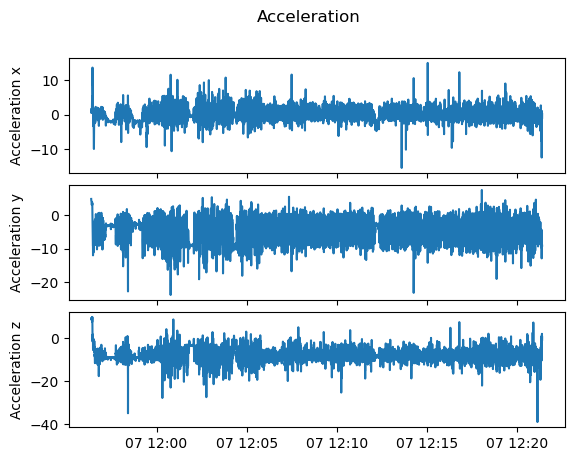

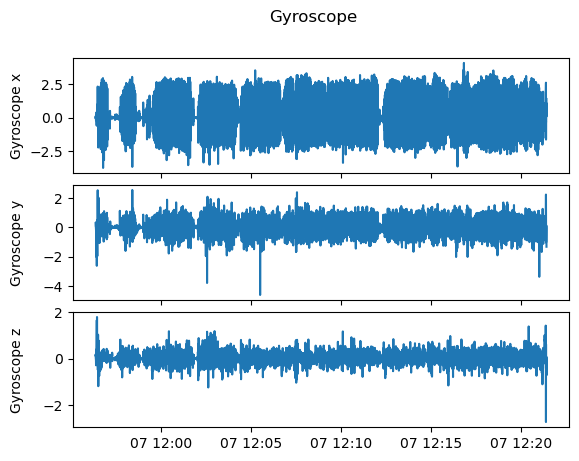

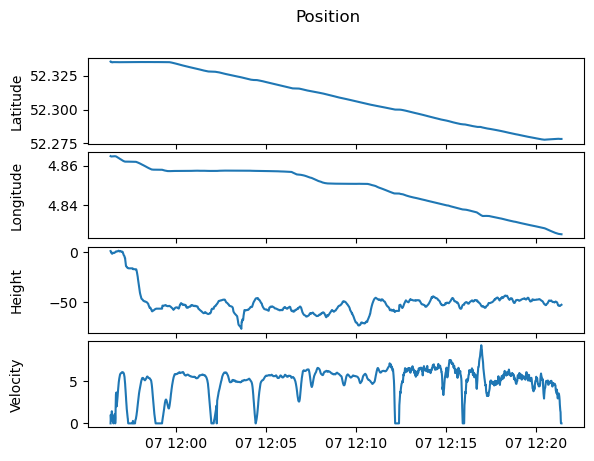

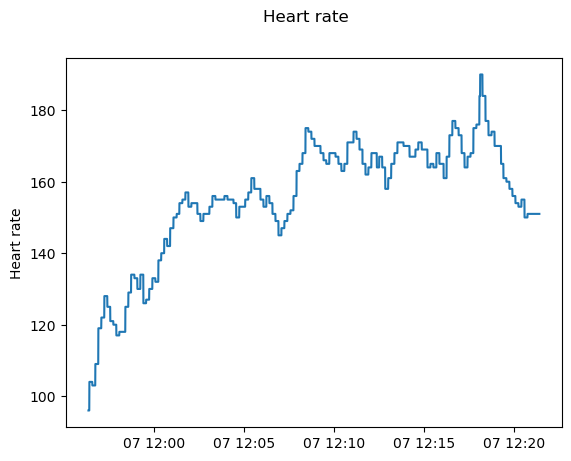

In [6]:
target_tram = "Tram 08-06-23 11:05"
target_walk = "Walk 08-06-23 10:41"

df = read_combined(target_dir2)

# Acceleration figure
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

fig.suptitle("Acceleration")

ax1.plot(df["time"], df["acceleration_x"])
ax1.set_ylabel("Acceleration x")

ax2.plot(df["time"], df["acceleration_y"])
ax2.set_ylabel("Acceleration y")

ax3.plot(df["time"], df["acceleration_z"])
ax3.set_ylabel("Acceleration z")

plt.subplots_adjust(hspace=0.1)
fig.align_labels()

# Gyroscope figure
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

fig.suptitle("Gyroscope")

ax1.plot(df["time"], df["gyroscope_x"])
ax1.set_ylabel("Gyroscope x")

ax2.plot(df["time"], df["gyroscope_y"])
ax2.set_ylabel("Gyroscope y")

ax3.plot(df["time"], df["gyroscope_z"])
ax3.set_ylabel("Gyroscope z")

plt.subplots_adjust(hspace=0.1)
fig.align_labels()

# Position figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)

fig.suptitle("Position")

ax1.plot(df["time"], df["latitude"])
ax1.set_ylabel("Latitude")

ax2.plot(df["time"], df["longitude"])
ax2.set_ylabel("Longitude")

ax3.plot(df["time"], df["height"])
ax3.set_ylabel("Height")

ax4.plot(df["time"], df["velocity"])
ax4.set_ylabel("Velocity")

plt.subplots_adjust(hspace=0.1)
fig.align_labels()

# Position figure
fig, ax = plt.subplots(1, sharex=True)

fig.suptitle("Heart rate")

ax.plot(df["time"], df["heart_rate"])
ax.set_ylabel("Heart rate")


plt.subplots_adjust(hspace=0.1)
fig.align_labels()